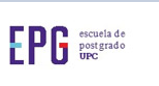

### **TRABAJO FINAL MODELOS GRAFICOS PROPABILISTICOS**

**GRUPO 6:**

**Integrantes:**  Vladimir Estrada / Jefferson Ruiz / Juliana Virhuez

---



#### **(1) Representación del MGM**


In [1]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
#from pgmpy.inference import VariableElimination, BeliefPropagation

In [21]:
#Librerias generales
import os
import random
import warnings
from scipy.io import arff

#Librerias PGMPY
import pgmpy.estimators as ests
from pgmpy.estimators import TreeSearch
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation
from pgmpy.metrics import structure_score

#Librerias para aprendizaje automatico en Python
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#Librerias para visualizaciones
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
random_state = 123
np.random.seed(random_state)
warnings.simplefilter('ignore')
np.set_printoptions(precision=2, suppress=True)

In [3]:
# Estructura del modelo

model = BayesianNetwork([
    ('tipo_cliente', 'Tipo_de_medio'),
    ('origen_del_medio', 'Tipo_de_medio'),
    ('Tipo_de_medio', 'Tipo_de_recurso'),
    ('Tipo_de_recurso', 'TipodeActividad'),
    ('TipodeActividad', 'DurationCategory'),
    ('turno_laboral', 'DurationCategory'),
    ('experiencia', 'CostPerActiv'),
    ('DurationCategory', 'CostPerActiv')
])

In [4]:

# Definir las CPDs
cpd_tipo_cliente = TabularCPD(variable='tipo_cliente', variable_card=2, values=[[0.995572], [0.004428]])

cpd_origen_del_medio = TabularCPD(variable='origen_del_medio', variable_card=2, values=[[0.036895], [0.963105]])

cpd_tipo_de_medio = TabularCPD(variable='Tipo_de_medio', variable_card=2,
    values=[[1.0, 1.0, 0.569854, 0.611374], [0.0, 0.0, 0.430146, 0.388626]],
    evidence=['tipo_cliente', 'origen_del_medio'], evidence_card=[2, 2])

cpd_tipo_de_recurso = TabularCPD(variable='Tipo_de_recurso', variable_card=3,
    values=[[0.498556, 0.571051], [0.501444, 0.0], [0.0, 0.428949]],
    evidence=['Tipo_de_medio'], evidence_card=[2])

cpd_tipodeactividad = TabularCPD(variable='TipodeActividad', variable_card=3,
    values=[[0.321160, 0.230298, 0.0], [0.567005, 0.224947, 0.666424], [0.111835, 0.544756, 0.333576]],
    evidence=['Tipo_de_recurso'], evidence_card=[3])

cpd_turno_laboral = TabularCPD(variable='turno_laboral', variable_card=3,
    values=[[0.302999], [0.526557], [0.170444]])

cpd_experiencia = TabularCPD(variable='experiencia', variable_card=3,
    values=[[0.505005], [0.195777], [0.299218]])

cpd_duration_category = TabularCPD(variable='DurationCategory', variable_card=3,
    values=[
        [0.000000, 0.000000, 0.000000, 0.132419, 0.157758, 0.040844, 0.361817, 0.434606, 0.070149],
        [0.908353, 0.925874, 0.885615, 0.686677, 0.662795, 0.788740, 0.464572, 0.391686, 0.733262],
        [0.091647, 0.074126, 0.114385, 0.180904, 0.179447, 0.170415, 0.173611, 0.173707, 0.196588]
    ],
    evidence=['TipodeActividad', 'turno_laboral'], evidence_card=[3, 3])

cpd_cost_per_activ = TabularCPD(variable='CostPerActiv', variable_card=3,
    values=[
        [0.001396, 0.011518, 0.092930, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.401480, 0.046327, 0.000000, 1.0, 1.0, 1.0, 1.0, 0.935613, 0.651525],
        [0.597123, 0.942155, 0.907070, 0.0, 0.0, 0.0, 0.0, 0.064387, 0.348475]
    ],
    evidence=['experiencia', 'DurationCategory'], evidence_card=[3, 3])

# Añadir las CPDs al modelo
model.add_cpds(cpd_tipo_cliente, cpd_origen_del_medio, cpd_tipo_de_medio, cpd_tipo_de_recurso,
               cpd_tipodeactividad, cpd_turno_laboral, cpd_experiencia, cpd_duration_category, cpd_cost_per_activ)



In [5]:
# Validar el modelo
assert model.check_model()

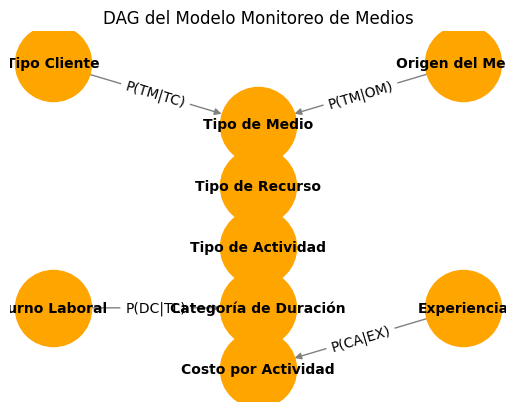

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

grafo = nx.DiGraph()

# Agregar nodos al grafo con etiquetas
grafo.add_node('tipo_cliente', label='Tipo Cliente')
grafo.add_node('origen_del_medio', label='Origen del Medio')
grafo.add_node('Tipo_de_medio', label='Tipo de Medio')
grafo.add_node('Tipo_de_recurso', label='Tipo de Recurso')
grafo.add_node('TipodeActividad', label='Tipo de Actividad')
grafo.add_node('DurationCategory', label='Categoría de Duración')
grafo.add_node('turno_laboral', label='Turno Laboral')
grafo.add_node('experiencia', label='Experiencia')
grafo.add_node('CostPerActiv', label='Costo por Actividad')

# Agregar aristas al grafo dirigido
grafo.add_edge('tipo_cliente', 'Tipo_de_medio', label='P(Tipo_de_medio|tipo_cliente)')
grafo.add_edge('origen_del_medio', 'Tipo_de_medio', label='P(Tipo_de_medio|origen_del_medio)')
grafo.add_edge('Tipo_de_medio', 'Tipo_de_recurso', label='P(Tipo_de_recurso|Tipo_de_medio)')
grafo.add_edge('Tipo_de_recurso', 'TipodeActividad', label='P(TipodeActividad|Tipo_de_recurso)')
grafo.add_edge('TipodeActividad', 'DurationCategory', label='P(DurationCategory|TipodeActividad)')
grafo.add_edge('turno_laboral', 'DurationCategory', label='P(DurationCategory|turno_laboral)')
grafo.add_edge('experiencia', 'CostPerActiv', label='P(CostPerActiv|experiencia)')
grafo.add_edge('DurationCategory', 'CostPerActiv', label='P(CostPerActiv|DurationCategory)')

# Definir posiciones específicas para los nodos


pos = {
    'tipo_cliente': (0, 10),
    'origen_del_medio': (10, 10),
    'Tipo_de_medio': (5, 8),
    'Tipo_de_recurso': (5, 6),
    'TipodeActividad': (5, 4),
    'DurationCategory': (5, 2),
    'turno_laboral': (0, 2),
    'experiencia': (10, 2),
    'CostPerActiv': (5, 0)
}

# Agregar etiquetas a las aristas (CPDs)
labels = {
    ('tipo_cliente', 'Tipo_de_medio'): 'P(TM|TC)',
    ('origen_del_medio', 'Tipo_de_medio'): 'P(TM|OM)',
    ('Tipo_de_medio', 'Tipo_de_recurso'): 'P(TR|TM)',
    ('Tipo_de_recurso', 'TipodeActividad'): 'P(TA|TR)',
    ('TipodeActividad', 'DurationCategory'): 'P(DC|TA)',
    ('turno_laboral', 'DurationCategory'): 'P(DC|TL)',
    ('experiencia', 'CostPerActiv'): 'P(CA|EX)',
    ('DurationCategory', 'CostPerActiv'): 'P(CA|DC)'
}

# Cargar las etiquetas a un diccionario
edge_labels = {(u, v): labels[(u, v)] for u, v in grafo.edges}

# Mostrar el grafo
nx.draw_networkx(grafo, pos=pos, with_labels=True, labels=nx.get_node_attributes(grafo, 'label'),
                 node_color='orange', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Mostrar las etiquetas en las aristas del grafo
nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels)

# Mostrar el grafo
plt.axis('off')
plt.title('DAG del Modelo Monitoreo de Medios')
plt.show()

#Importando el Dataset

In [8]:
path = 'TablaMedios.csv'
df = pd.read_csv(path, delimiter=';')
df.head(5)

,IDRow,CaseID,TipoActividad,TipoRecurso,TimestampStart,DuracionActividad,DurationCategory,Sorting,CATEGORIAMEDIO,TipoMedio,OrigenMedio,TurnoLaboral,TipoCliente,TipodeActividad,UserID,CostPerHour,Experiencia,CostoActividad,CostPerActiv,Unnamed: 19
0,1,1,Digitalizar Medios Impresos,Soporte,2/01/23 5:15,23.52,Alta,1,DIARIO,ESCRITO,NACIONAL,NOCHE,PRIVADO,Producción,Soporte8,12.0,SemiSenior,6.35,ALTO,NaN
1,2,1,Descarga Pdf del Kiosko Digital,Soporte,2/01/23 5:38,0.00,Baja,2,DIARIO,ESCRITO,NACIONAL,NOCHE,PRIVADO,Operación,Soporte10,12.0,SemiSenior,0.00,BAJO,NaN
2,3,1,Ingresar a la Plataforma,Soporte,2/01/23 5:38,0.00,Baja,3,DIARIO,ESCRITO,NACIONAL,NOCHE,PRIVADO,Operación,Soporte2,18.0,Senior,0.00,BAJO,NaN
3,4,1,Identificar Palabras Clave,Coleccionista,2/01/23 5:38,0.00,Baja,4,DIARIO,ESCRITO,NACIONAL,NOCHE,PRIVADO,Análisis,Coleccionista8,9.0,Junior,0.00,BAJO,NaN
4,5,1,Cortar Noticias de Interes,Coleccionista,2/01/23 5:38,0.00,Baja,5,DIARIO,ESCRITO,NACIONAL,NOCHE,PRIVADO,Operación,Coleccionista4,20.0,Senior,0.00,BAJO,NaN


In [9]:
df.isnull().sum(axis=0)

IDRow                     0
CaseID                    0
TipoActividad             0
TipoRecurso               0
TimestampStart            0
DuracionActividad         0
DurationCategory          0
Sorting                   0
CATEGORIAMEDIO            0
TipoMedio                 0
OrigenMedio               0
TurnoLaboral              0
TipoCliente               0
TipodeActividad           0
UserID                    0
CostPerHour               0
Experiencia               0
CostoActividad            0
CostPerActiv              0
Unnamed: 19          100502
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100502 entries, 0 to 100501
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   IDRow              100502 non-null  int64  
 1   CaseID             100502 non-null  int64  
 2   TipoActividad      100502 non-null  object 
 3   TipoRecurso        100502 non-null  object 
 4   TimestampStart     100502 non-null  object 
 5   DuracionActividad  100502 non-null  float64
 6   DurationCategory   100502 non-null  object 
 7   Sorting            100502 non-null  int64  
 8   CATEGORIAMEDIO     100502 non-null  object 
 9   TipoMedio          100502 non-null  object 
 10  OrigenMedio        100502 non-null  object 
 11  TurnoLaboral       100502 non-null  object 
 12  TipoCliente        100502 non-null  object 
 13  TipodeActividad    100502 non-null  object 
 14  UserID             100502 non-null  object 
 15  CostPerHour        100502 non-null  float64
 16  Ex

#Limpiando Dataset

Eliminando Duracion actividad cero


In [11]:
# Eliminar las filas donde DuracionActividad es igual a cero
df = df[df['DuracionActividad'] != 0]





Primeras 5 filas después de la eliminación:
   IDRow  CaseID                    TipoActividad    TipoRecurso  \
0      1       1      Digitalizar Medios Impresos        Soporte   
6      7       1        Enviar a Clientes Boletin  Coleccionista   
7      8       2      Digitalizar Medios Impresos        Soporte   
8      9       2  Descarga Pdf del Kiosko Digital        Soporte   
9     10       2         Ingresar a la Plataforma        Soporte   

  TimestampStart  DuracionActividad DurationCategory  Sorting CATEGORIAMEDIO  \
0   2/01/23 5:15              23.52             Alta        1         DIARIO   
6   2/01/23 5:38               1.00             Baja        7         DIARIO   
7   2/01/23 5:38               5.77             Alta        8         DIARIO   
8   2/01/23 5:44               0.56             Baja        9         DIARIO   
9   2/01/23 5:44               1.11            Media       10         DIARIO   

  TipoMedio OrigenMedio TurnoLaboral TipoCliente TipodeActividad 

Manteniendo COlumnas relevantes

In [13]:
columns_to_keep = [
    'TipoRecurso', 'DurationCategory', 'TipoMedio', 'CATEGORIAMEDIO',
    'OrigenMedio', 'TurnoLaboral', 'TipoCliente', 'TipodeActividad',
    'Experiencia', 'CostPerActiv'
]
df = df[columns_to_keep]

# Mostrar las primeras 5 filas del dataframe después de la eliminación
print("\nPrimeras 5 filas después de la eliminación:")
print(df.head(5))


Primeras 5 filas después de la eliminación:
     TipoRecurso DurationCategory TipoMedio CATEGORIAMEDIO OrigenMedio  \
0        Soporte             Alta   ESCRITO         DIARIO    NACIONAL   
6  Coleccionista             Baja   ESCRITO         DIARIO    NACIONAL   
7        Soporte             Alta   ESCRITO         DIARIO    NACIONAL   
8        Soporte             Baja   ESCRITO         DIARIO    NACIONAL   
9        Soporte            Media   ESCRITO         DIARIO    NACIONAL   

  TurnoLaboral TipoCliente TipodeActividad Experiencia CostPerActiv  
0        NOCHE     PRIVADO      Producción  SemiSenior         ALTO  
6        NOCHE     PRIVADO       Operación      Junior         BAJO  
7        NOCHE     PRIVADO      Producción      Senior        MEDIO  
8        NOCHE     PRIVADO       Operación      Junior         BAJO  
9        NOCHE     PRIVADO       Operación      Junior         BAJO  


In [14]:
# Mostrar los valores únicos de cada columna
for column in columns_to_keep:
    unique_values = df[column].unique()
    print(f"{column}: {unique_values}")

TipoRecurso: ['Soporte' 'Coleccionista' 'Redactor']
DurationCategory: ['Alta' 'Baja' 'Media']
TipoMedio: ['ESCRITO' 'AUDIOVISUAL']
CATEGORIAMEDIO: ['DIARIO' 'TV AIRE' 'TV CABLE' 'YOUTUBE' 'RADIO']
OrigenMedio: ['NACIONAL' 'INTERNACIONAL']
TurnoLaboral: ['NOCHE' 'MANANA' 'TARDE']
TipoCliente: ['PRIVADO' 'PUBLICO']
TipodeActividad: ['Producción' 'Operación' 'Análisis']
Experiencia: ['SemiSenior' 'Junior' 'Senior']
CostPerActiv: ['ALTO' 'BAJO' 'MEDIO']


#Pre Procesar Datos

Haciendo Mapping

In [15]:
mappings = {
    'TipoRecurso': {'Soporte': 0, 'Coleccionista': 1, 'Redactor': 2},
    'DurationCategory': {'Baja': 0, 'Media': 1, 'Alta': 2},
    'TipoMedio': {'ESCRITO': 0, 'AUDIOVISUAL': 1},
    'CATEGORIAMEDIO': {'DIARIO': 0, 'RADIO': 1, 'TV AIRE': 2, 'TV CABLE': 3, 'YOUTUBE': 4},
    'OrigenMedio': {'NACIONAL': 0, 'INTERNACIONAL': 1},
    'TurnoLaboral': {'MANANA': 0, 'TARDE': 1, 'NOCHE': 2},
    'TipoCliente': {'PRIVADO': 0, 'PUBLICO': 1},
    'TipodeActividad': {'Producción': 0, 'Operación': 1, 'Análisis': 2},
    'Experiencia': {'Junior': 0, 'SemiSenior': 1, 'Senior': 2},
    'CostPerActiv': {'BAJO': 0, 'MEDIO': 1, 'ALTO': 2}
}



Reemplazando Mapping en df

In [16]:
# Reemplazar los valores en el dataframe
for column, mapping in mappings.items():
    df[column] = df[column].map(mapping)

# Mostrar la información del dataframe después de los reemplazos
print("Información del dataframe después de los reemplazos:")
print(df.info())

# Mostrar las primeras 5 filas del dataframe después de los reemplazos
print("\nPrimeras 5 filas después de los reemplazos:")
print(df.head(5))

Información del dataframe después de los reemplazos:
<class 'pandas.core.frame.DataFrame'>
Index: 94889 entries, 0 to 100501
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   TipoRecurso       94889 non-null  int64
 1   DurationCategory  94889 non-null  int64
 2   TipoMedio         94889 non-null  int64
 3   CATEGORIAMEDIO    94889 non-null  int64
 4   OrigenMedio       94889 non-null  int64
 5   TurnoLaboral      94889 non-null  int64
 6   TipoCliente       94889 non-null  int64
 7   TipodeActividad   94889 non-null  int64
 8   Experiencia       94889 non-null  int64
 9   CostPerActiv      94889 non-null  int64
dtypes: int64(10)
memory usage: 8.0 MB
None

Primeras 5 filas después de los reemplazos:
   TipoRecurso  DurationCategory  TipoMedio  CATEGORIAMEDIO  OrigenMedio  \
0            0                 2          0               0            0   
6            1                 0          0               0  

# Definición de los datos de entrada

In [17]:
X = (df.iloc[:, :-1])
y = (df.iloc[:, -1])

In [18]:
X.head()

,TipoRecurso,DurationCategory,TipoMedio,CATEGORIAMEDIO,OrigenMedio,TurnoLaboral,TipoCliente,TipodeActividad,Experiencia
0,0,2,0,0,0,2,0,0,1
6,1,0,0,0,0,2,0,1,0
7,0,2,0,0,0,2,0,0,2
8,0,0,0,0,0,2,0,1,0
9,0,1,0,0,0,2,0,1,0


In [19]:
y.head()

0    2
6    0
7    1
8    0
9    0
Name: CostPerActiv, dtype: int64

# Ingeniería de características

Top Features

In [23]:
#Seleccionamos las 8 mejores variables de las 12 disponibles, ordenadas de mayor a menor puntaje obtenido (mayor correlacionadas)
fs = SelectKBest(score_func=chi2, k=8)
f_best = fs.fit_transform(X, y)

top_features = sorted(zip(list(X.columns), fs.scores_), key=lambda x: x[1], reverse=True)
top_features

[('DurationCategory', 65896.89342679008),
 ('CATEGORIAMEDIO', 15269.602157561076),
 ('TipoMedio', 6426.712625894735),
 ('TipodeActividad', 5901.077083971824),
 ('TipoRecurso', 4471.402049367017),
 ('Experiencia', 3701.979662050336),
 ('TurnoLaboral', 974.5889359309084),
 ('OrigenMedio', 423.4144459815204),
 ('TipoCliente', 0.37926188693399604)]

In [27]:
# Obtener las columnas seleccionadas
selected_columns = X.columns[fs.get_support()].tolist()

# Obtener las columnas no seleccionadas
non_selected_columns = [col for col in X.columns if col not in selected_columns]

# Mostrar las columnas seleccionadas y no seleccionadas
print("Columnas no TopFeature:", non_selected_columns)

Columnas no TopFeature: ['TipoCliente']


Spearman

In [25]:
import seaborn as sns

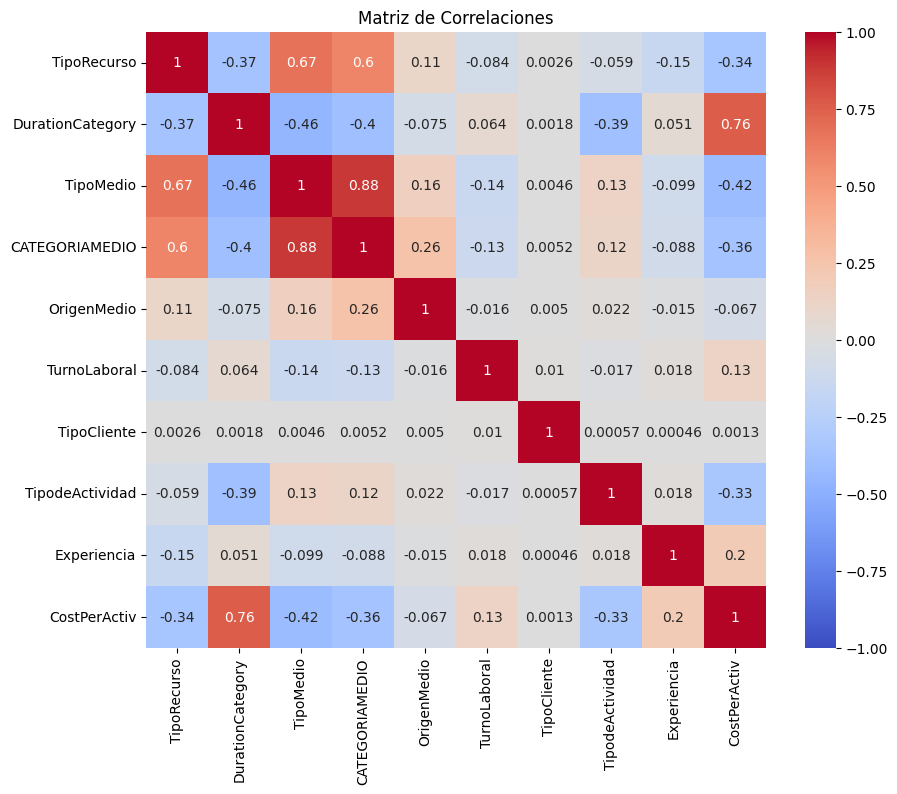

In [26]:
# Calcular la matriz de correlaciones
corr_matrix = df.corr()

# Visualizar la matriz de correlaciones usando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlaciones')
plt.savefig('corr_spr.png')
plt.show()

Creación del nuevo DF sin variables con menor puntaje

In [28]:
#Quitamos TipoCliente y OrigenMedio
df = df.drop(['TipoCliente','OrigenMedio'], axis=1)

data = df

#Adicionamos al dataset tambien el target
data[df.columns[-1]] = y
data.head()


,TipoRecurso,DurationCategory,TipoMedio,CATEGORIAMEDIO,TurnoLaboral,TipodeActividad,Experiencia,CostPerActiv
0,0,2,0,0,2,0,1,2
6,1,0,0,0,2,1,0,0
7,0,2,0,0,2,0,2,1
8,0,0,0,0,2,1,0,0
9,0,1,0,0,2,1,0,0


#Modelo de Red Bayesiana

Gráfico acíclico dirigido probabilístico - pDAG

Building tree:   0%|          | 0/28.0 [00:00<?, ?it/s]

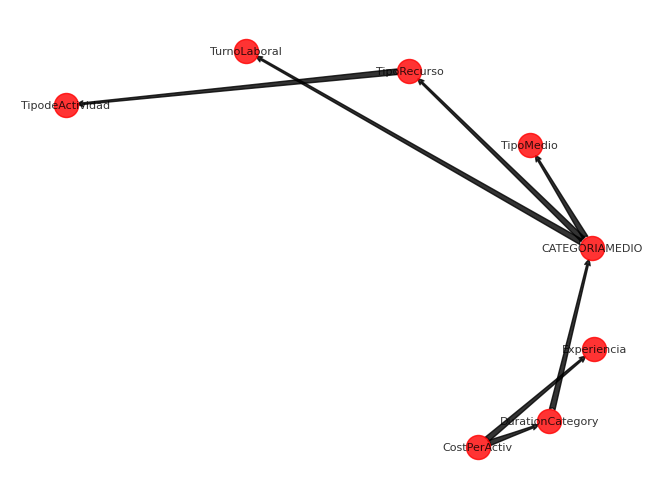

In [32]:
#Especificamos el nodo que debera ser el raiz utilizando el algoritmo de arboles pq el dataset tienen mas de 4 nodos o variables
est = TreeSearch(data, root_node='CostPerActiv')
#En la variable dag contendremos la red bayesiana obtenida por Aprendizaje Estructurado utilizando el estimador de tipo chow-liu
dag = est.estimate(estimator_type='chow-liu')
#Mostramos el DAG con un layout de tipo spiral
pos = nx.spiral_layout(dag)
nx.draw(dag, pos=pos, with_labels=True,node_color='r', font_size=8, arrowstyle='fancy', alpha=0.8)
#Guardamos el grafo DAG en un archivo .png que podemos visualizar y/o descargar
plt.savefig('plt.png')

Información del DAG

In [33]:
print("Nodos: ", dag.nodes())
print("---------------")
print("Aristas: ", dag.edges())

print("--------" "\n")

print("Origen y destino de las Aristas")
print("-------------------------------" "\n")
nx.to_pandas_edgelist(dag)

Nodos:  ['CostPerActiv', 'DurationCategory', 'Experiencia', 'CATEGORIAMEDIO', 'TipoMedio', 'TipoRecurso', 'TurnoLaboral', 'TipodeActividad']
---------------
Aristas:  [('CostPerActiv', 'DurationCategory'), ('CostPerActiv', 'Experiencia'), ('DurationCategory', 'CATEGORIAMEDIO'), ('CATEGORIAMEDIO', 'TipoMedio'), ('CATEGORIAMEDIO', 'TipoRecurso'), ('CATEGORIAMEDIO', 'TurnoLaboral'), ('TipoRecurso', 'TipodeActividad')]
--------

Origen y destino de las Aristas
-------------------------------



,source,target,weight
0,CostPerActiv,DurationCategory,None
1,CostPerActiv,Experiencia,None
2,DurationCategory,CATEGORIAMEDIO,None
3,CATEGORIAMEDIO,TipoMedio,None
4,CATEGORIAMEDIO,TipoRecurso,None
5,CATEGORIAMEDIO,TurnoLaboral,None
6,TipoRecurso,TipodeActividad,None


Creando la Red Bayesiana

In [34]:
#A partir del DAG (Grafo Dirigido Aciclico) creamos la red bayesiana
model = BayesianNetwork(dag)
#A partir del modelo creado generamos los CPDs automaticamente a partir del metod fit.
#El metodo fit lo aplicamos al modelo teniendo como parametro el conjunto de datos
model.fit(data)
model.get_cpds()

[<TabularCPD representing P(CostPerActiv:3) at 0x7f36146b7130>,
 <TabularCPD representing P(DurationCategory:3 | CostPerActiv:3) at 0x7f351087e230>,
 <TabularCPD representing P(Experiencia:3 | CostPerActiv:3) at 0x7f351087e8c0>,
 <TabularCPD representing P(CATEGORIAMEDIO:5 | DurationCategory:3) at 0x7f351087c2b0>,
 <TabularCPD representing P(TipoMedio:2 | CATEGORIAMEDIO:5) at 0x7f35108a6ce0>,
 <TabularCPD representing P(TipoRecurso:3 | CATEGORIAMEDIO:5) at 0x7f35108a5780>,
 <TabularCPD representing P(TurnoLaboral:3 | CATEGORIAMEDIO:5) at 0x7f35108a74c0>,
 <TabularCPD representing P(TipodeActividad:3 | TipoRecurso:3) at 0x7f35108a7520>]

In [37]:
for cpd in model.get_cpds():
    print(cpd)

+-----------------+------------+
| CostPerActiv(0) | 0.841141   |
+-----------------+------------+
| CostPerActiv(1) | 0.153168   |
+-----------------+------------+
| CostPerActiv(2) | 0.00569086 |
+-----------------+------------+
+---------------------+---------------------+---------------------+-----------------+
| CostPerActiv        | CostPerActiv(0)     | CostPerActiv(1)     | CostPerActiv(2) |
+---------------------+---------------------+---------------------+-----------------+
| DurationCategory(0) | 0.7873707949633527  | 0.0                 | 0.0             |
+---------------------+---------------------+---------------------+-----------------+
| DurationCategory(1) | 0.17434066278268495 | 0.12680610981147653 | 0.0             |
+---------------------+---------------------+---------------------+-----------------+
| DurationCategory(2) | 0.03828854225396229 | 0.8731938901885234  | 1.0             |
+---------------------+---------------------+---------------------+--------------

Adicional para tener los CPDS con nombres

In [48]:
# A partir del DAG (Grafo Dirigido Aciclico) creamos la red bayesiana
model2 = BayesianNetwork(dag)

# Definir state_names para cada variable
state_names = {
    'TipoRecurso': ['Soporte', 'Coleccionista', 'Redactor'],
    'DurationCategory': ['Baja', 'Media', 'Alta'],
    'TipoMedio': ['ESCRITO', 'AUDIOVISUAL'],
    'CATEGORIAMEDIO': ['DIARIO', 'RADIO', 'TV AIRE', 'TV CABLE', 'YOUTUBE'],
    'OrigenMedio': ['NACIONAL', 'INTERNACIONAL'],
    'TurnoLaboral': ['MANANA', 'TARDE', 'NOCHE'],
    'TipoCliente': ['PRIVADO', 'PUBLICO'],
    'TipodeActividad': ['Producción', 'Operación', 'Análisis'],
    'Experiencia': ['Junior', 'SemiSenior', 'Senior'],
    'CostPerActiv': ['BAJO', 'MEDIO', 'ALTO']
}

# A partir del modelo creado generamos los CPDs automáticamente a partir del método fit.
# El método fit lo aplicamos al modelo teniendo como parámetro el conjunto de datos
model2.fit(data)

# Verificar que todos los nodos en state_names estén en el modelo
for var in state_names:
    if var in model2.nodes():
        cpd = model2.get_cpds(var)
        cpd.state_names = {var: state_names[var]}
        for parent in cpd.variables[1:]:
            cpd.state_names[parent] = state_names[parent]
        model2.add_cpds(cpd)
    else:
        print(f"Warning: Variable {var} is not in the model")

# Imprimir los CPDs con los labels originales
for cpd in model2.get_cpds():
    print(cpd)



+---------------------+------------+
| CostPerActiv(BAJO)  | 0.841141   |
+---------------------+------------+
| CostPerActiv(MEDIO) | 0.153168   |
+---------------------+------------+
| CostPerActiv(ALTO)  | 0.00569086 |
+---------------------+------------+
+-------------------------+---------------------+---------------------+--------------------+
| CostPerActiv            | CostPerActiv(BAJO)  | CostPerActiv(MEDIO) | CostPerActiv(ALTO) |
+-------------------------+---------------------+---------------------+--------------------+
| DurationCategory(Baja)  | 0.7873707949633527  | 0.0                 | 0.0                |
+-------------------------+---------------------+---------------------+--------------------+
| DurationCategory(Media) | 0.17434066278268495 | 0.12680610981147653 | 0.0                |
+-------------------------+---------------------+---------------------+--------------------+
| DurationCategory(Alta)  | 0.03828854225396229 | 0.8731938901885234  | 1.0               

Cpd con tablas incompletas:

In [49]:

# Función para imprimir CPD en formato tabular
def print_cpd(cpd):
    variables = [cpd.variable] + cpd.get_evidence()
    state_names = cpd.state_names
    cpd_values = cpd.values

    if cpd.get_evidence():
        columns = pd.MultiIndex.from_product([state_names[var] for var in cpd.get_evidence()], names=cpd.get_evidence())
        index = [f"{cpd.variable}({state})" for state in state_names[cpd.variable]]
        df = pd.DataFrame(cpd_values.reshape(len(state_names[cpd.variable]), -1), index=index, columns=columns)
    else:
        index = [f"{cpd.variable}({state})" for state in state_names[cpd.variable]]
        df = pd.DataFrame(cpd_values, index=index, columns=[cpd.variable])

    print(f"CPD de {cpd.variable}:")
    print(df.to_string())
    print("\n")

# Imprimir las CPDs para ver los resultados
for cpd in model2.get_cpds():
    print_cpd(cpd)


CPD de CostPerActiv:
                     CostPerActiv
CostPerActiv(BAJO)       0.841141
CostPerActiv(MEDIO)      0.153168
CostPerActiv(ALTO)       0.005691


CPD de DurationCategory:
CostPerActiv                 BAJO     MEDIO ALTO
DurationCategory(Baja)   0.787371  0.000000  0.0
DurationCategory(Media)  0.174341  0.126806  0.0
DurationCategory(Alta)   0.038289  0.873194  1.0


CPD de Experiencia:
CostPerActiv                 BAJO     MEDIO      ALTO
Experiencia(Junior)      0.551976  0.294207  0.018519
Experiencia(SemiSenior)  0.181357  0.267648  0.083333
Experiencia(Senior)      0.266667  0.438145  0.898148


CPD de CATEGORIAMEDIO:
DurationCategory              Baja     Media      Alta
CATEGORIAMEDIO(DIARIO)    0.247804  0.403858  0.866397
CATEGORIAMEDIO(RADIO)     0.032207  0.021957  0.003745
CATEGORIAMEDIO(TV AIRE)   0.479743  0.375492  0.082397
CATEGORIAMEDIO(TV CABLE)  0.135224  0.094555  0.020077
CATEGORIAMEDIO(YOUTUBE)   0.105022  0.104138  0.027384


CPD de TipoMedio:
CATEGOR

#Predicciones

In [35]:
#np.squeeze recibe los valores de un dataset en formato arreglo y devuelve un array conteniendo los valores de la(s) columna(s) especificadas
test = np.squeeze(data.iloc[:, -1].values)

#las valores de la columna a predecir se encuentra en la ultima columna del dataset, justamente es la variable DEATH_EVENT
predict_data = data.iloc[:, :-1]

#la variable y_pred contiene el resultado de ejecutar el metodo predict al modelo, pasando como argumento el dataset de prueba que no contiene la variable a predecir
# DEATH_EVENT
y_pred = model.predict(predict_data)

#Obtenemos el puntaje de precision del modelo comparando los valores obtenidos de la prediccion en y_pred.values vs los valores de la variable DEATH_EVENT de la
# variable test.  Ambas variables en formato array de numpy.  Obtenemos una precision de 93.6%
print(accuracy_score(np.squeeze(y_pred.values), test))

  0%|          | 0/437 [00:00<?, ?it/s]

0.9426803949878279


In [39]:
data.head()

,TipoRecurso,DurationCategory,TipoMedio,CATEGORIAMEDIO,TurnoLaboral,TipodeActividad,Experiencia,CostPerActiv
0,0,2,0,0,2,0,1,2
6,1,0,0,0,2,1,0,0
7,0,2,0,0,2,0,2,1
8,0,0,0,0,2,1,0,0
9,0,1,0,0,2,1,0,0


#Inferencias

In [54]:

# Crear un objeto para realizar la inferencia
infer = VariableElimination(model)

def print_inference(query_result, variable):
    for factor in query_result.values():
        print(factor)
        for i, state in enumerate(mappings[variable]):
            percentage = factor.values[i] * 100
            print(f"{variable}({state}): {percentage:.2f}%")
    print("\n" * 2)

# 1. Probabilidad de que el costo por actividad sea alto dado que el recurso es un coleccionista con experiencia junior y la actividad es de operación
q1 = infer.query(variables=["CostPerActiv"], evidence={"TipoRecurso": 1, "Experiencia": 0, "TipodeActividad": 1}, joint=False)
print("Probabilidad de que el costo por actividad sea alto dado que el recurso es un coleccionista con experiencia junior y la actividad es de operación:")
print_inference(q1, "CostPerActiv")

# 2. Probabilidad de que el costo por actividad sea bajo dado que el turno laboral es de mañana y la actividad es de análisis
q2 = infer.query(variables=["CostPerActiv"], evidence={"TurnoLaboral": 0, "TipodeActividad": 2}, joint=False)
print("Probabilidad de que el costo por actividad sea bajo dado que el turno laboral es de mañana y la actividad es de análisis:")
print_inference(q2, "CostPerActiv")

# 3. Probabilidad de que el costo por actividad sea medio dado que el tipo de medio es audiovisual y el recurso es un redactor con experiencia senior
q3 = infer.query(variables=["CostPerActiv"], evidence={"TipoMedio": 1, "TipoRecurso": 2, "Experiencia": 2}, joint=False)
print("Probabilidad de que el costo por actividad sea medio dado que el tipo de medio es audiovisual y el recurso es un redactor con experiencia senior:")
print_inference(q3, "CostPerActiv")

# 4. Probabilidad de que el costo por actividad sea alto dado que el turno laboral es de noche y la actividad es de producción
q4 = infer.query(variables=["CostPerActiv"], evidence={"TurnoLaboral": 2, "TipodeActividad": 0}, joint=False)
print("Probabilidad de que el costo por actividad sea alto dado que el turno laboral es de noche y la actividad es de producción:")
print_inference(q4, "CostPerActiv")

# 5. Probabilidad de que la duración de las tareas sea alta dado que el tipo de recurso es soporte y el turno laboral es de noche
q5 = infer.query(variables=["DurationCategory"], evidence={"TipoRecurso": 0, "TurnoLaboral": 2}, joint=False)
print("Probabilidad de que la duración de las tareas sea alta dado que el tipo de recurso es soporte y el turno laboral es de noche:")
print_inference(q5, "DurationCategory")


Probabilidad de que el costo por actividad sea alto dado que el recurso es un coleccionista con experiencia junior y la actividad es de operación:
+-----------------+---------------------+
| CostPerActiv    |   phi(CostPerActiv) |
+=================+=====================+
| CostPerActiv(0) |              0.9060 |
+-----------------+---------------------+
| CostPerActiv(1) |              0.0938 |
+-----------------+---------------------+
| CostPerActiv(2) |              0.0002 |
+-----------------+---------------------+
CostPerActiv(BAJO): 90.60%
CostPerActiv(MEDIO): 9.38%
CostPerActiv(ALTO): 0.02%



Probabilidad de que el costo por actividad sea bajo dado que el turno laboral es de mañana y la actividad es de análisis:
+-----------------+---------------------+
| CostPerActiv    |   phi(CostPerActiv) |
+=================+=====================+
| CostPerActiv(0) |              0.8637 |
+-----------------+---------------------+
| CostPerActiv(1) |              0.1315 |
+-----------------